# Simulating LISA data

This notebook will walk through how to simulate LISA data using the `lisaorbits`, `lisagwresponse`, `lisainstrument` and `pytdi` packages. These are the main steps:
1. Generate LISA's orbit (`lisaorbit`)
2. Generate GW response (`lisagwresponse`)
3. Generate instrument noise (`lisainstrument`) and inject GW + Orbit data
4. Compute TDI observables (`pytdi`)

!!WARNING
The runtime for simulating more than a few hours of data using this code-suite is expensive. Look the following plot (generated using the data from Figure 9, blue curve, top right panel of [Bayle et al. 2023](https://arxiv.org/abs/2212.05351)):
![](images/runtime.png)

In this tutorial we will only be simulating 1 hour of data. This takes about 10 minutes on my laptop.

If you want to use pre-simulated data, you can use the [LISA Data Challenge](https://lisa-data-challenge.lal.in2p3.fr/) data.



### Acknowledgements
These notes were compiled using a variety of sources:
- [Q. Baghi's paper on the LISA data challenge](https://arxiv.org/pdf/2204.12142.pdf)
- [LDC workshop](https://colab.research.google.com/drive/1BB5gAynmvAXExrphOWVD_3LlX31nPNWW?usp=sharing#scrollTo=fn5FAaJK9Try)
- [Jean-Baptiste Bayle's paper on the LISA simulation suite](https://arxiv.org/abs/2212.05351)




## Installation and setup

We start with some installs:

In [182]:
! pip install lisaorbits -q
! pip install lisagwresponse -q
! pip install lisainstrument -q
! pip install pytdi -q
! pip install jupyter-autotime -q
! pip install memory_profiler -q
! pip install legwork -q

Sprinkle in some _magic_:

In [183]:
%matplotlib inline
%load_ext memory_profiler
%load_ext autotime

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [184]:
import lisaorbits, lisainstrument, lisagwresponse
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
import shutil
import h5py


def set_logger_level(loggers, level):
    for l in loggers:
        logger = logging.getLogger(l)
        logger.setLevel(level)


set_logger_level(
    ['lisaorbits', 'lisainstrument', 'lisagwresponse', 'pytdi'],
    logging.INFO
)

SEC_IN_HOUR = 60 * 60  # seconds
SEC_IN_DAY = 24 * SEC_IN_HOUR  # seconds
SEC_IN_YEAR = int(365.25 * SEC_IN_DAY)  # seconds

In [185]:
CLEAN = True
OUTDIR = "simulated_lisa_data"

orbits_fn = f"{OUTDIR}/keplerian.hdf5"
gws_fn = f"{OUTDIR}/gws.hdf5"
instrument_fn = f"{OUTDIR}/instrument.hdf5"
tdi_fn = f"{OUTDIR}/tdi.hdf5"

if CLEAN and os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

dt = 0.25  # s
fs = 1 / dt  # Hz

## LISA Orbit generation

We can generate the LISA spacecraft orbits once and save them to a file. This is done using the `lisaorbits` package. The package has a few different types of 'Orbits':

In [186]:
for name in dir(lisaorbits.orbits):
    if 'Orbit' in name:
        print(name)

EqualArmlengthOrbits
InterpolatedOrbits
KeplerianOrbits
OEMOrbits
OrbitEphemerisMessage
Orbits
ResampledOrbits


We will generate a simple Keplerian orbit with equal arm lengths for N_YEARS_OF_OBS years and save the data.

We will also make some plots of the orbits. Note the LISA naming convention for the spacecrafts:
* 3 spacecraft, labeled 1, 2, 3
* 2 movable assemblies (MOSAs) per spacecraft, labelled 12 and 13, 23 and 21, 31 and 32

The MOSAs are the optical benches hold the laser interferometers and other stuff. Each MOSA has three interferometers, of which only the ISI (inter-spacecraft interferometer) is used for GW detection.


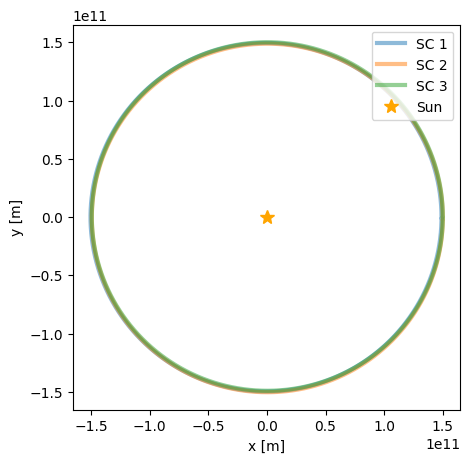

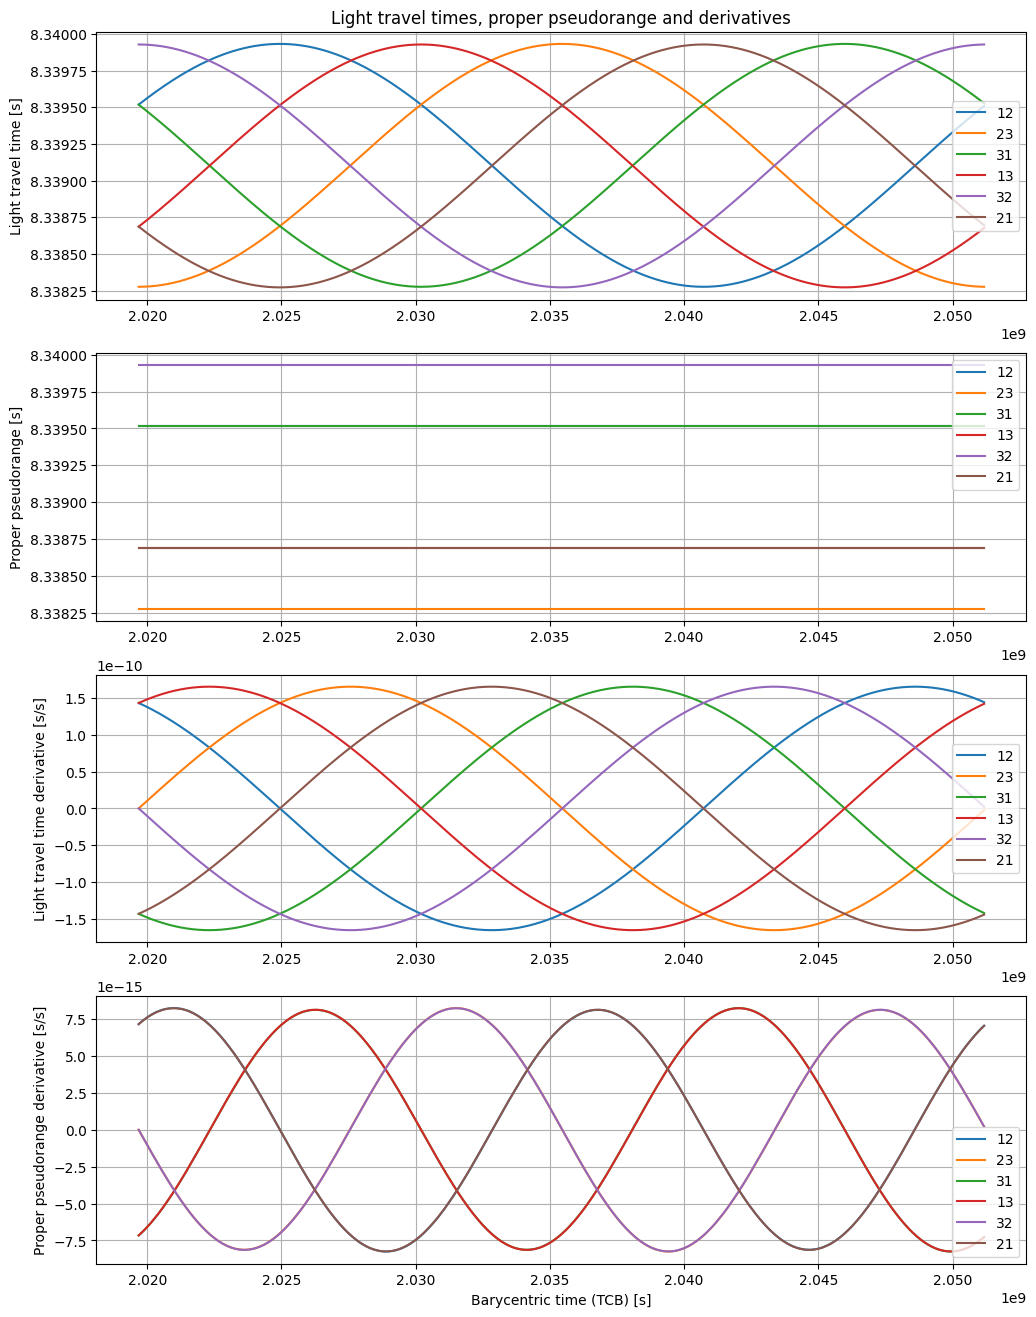

In [187]:
# NOTE: This section is solely for generating some mock orbits to plot -- dont use for the simulation!
dt = 60 * 60 * 12  # s
fs = 1 / dt  # Hz
N_YEARS_OF_OBS = 1
duration = N_YEARS_OF_OBS * SEC_IN_YEAR  # seconds
datasize = duration * fs  # samples
orbit_for_plotting = lisaorbits.EqualArmlengthOrbits(
    dt=dt, size=datasize
)


def plot_spacecraft_positions(orbit):
    sc_positions = orbit.compute_position(orbit.t, [1, 2, 3])
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    kwgs = dict(alpha=0.5, lw=3)
    ax.plot(sc_positions[:, 0, 0], sc_positions[:, 0, 1], label='SC 1', **kwgs)
    ax.plot(sc_positions[:, 1, 0], sc_positions[:, 1, 1], label='SC 2', **kwgs)
    ax.plot(sc_positions[:, 2, 0], sc_positions[:, 2, 1], label='SC 3', **kwgs)
    ax.plot(0, 0, '*', color='orange', markersize=10, label='Sun')
    ax.legend(loc='upper right')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')


plot_spacecraft_positions(orbit_for_plotting)
orbit_for_plotting.plot_links()

In [188]:
# Now some more realistic orbits for the simulation

N_ORBIT_DAYS = 3
dt = 0.25  # s
fs = 1 / dt  # Hz
duration = N_ORBIT_DAYS * SEC_IN_DAY  # seconds
datasize = duration * fs  # samples
print(f"Orbit datalen: {datasize:,} ({N_ORBIT_DAYS} days)")

if not os.path.isfile(orbits_fn):
    print("Generating orbit file...")
    orbit = lisaorbits.EqualArmlengthOrbits(
        dt=dt,  # seconds (data sampling time)
        size=datasize,  # number of data points
        t0=0,  # start time
    )
    orbit.write(orbits_fn)
    print("Orbit file saved!")
else:
    print("Using cached orbit file")

# loading the orbit t0
with h5py.File(orbits_fn) as f:
    orbits_t0 = f.attrs['t0']
    orbit_size = f.attrs['size']
    orbit_duration = orbit_size * f.attrs['dt']
    orbit_t = orbits_t0 + np.arange(orbit_size) * f.attrs['dt']
    orbit_n_days = (orbit_t[-1]-orbit_t[0])/SEC_IN_DAY
    print(f"Loaded Orbit size: {orbit_size:,} ({orbit_n_days:.2} days)")

Orbit datalen: 1,036,800.0 (3 days)
Generating orbit file...
Orbit file saved!
Loaded Orbit size: 1,036,800 (3.0 days)


## GW Response

Given the orbit, we can generate the response of GW signals on the 6 LISA links (sometimes called "projections") using the `lisagwresponse` package.

The package has a few different types of 'GWs':
- lisagwresponse.response.VerificationBinary
- lisagwresponse.response.GalacticBinary
- lisagwresponse.response.StochasticBackground
- lisagwresponse.response.StochasticPointSource

In the following bit of code we will generate a few different GW sources and demonstrate how we can add them together. We will also save the GW data to a file.

!NOTE!
We need to add some padding to the start and end of the data to avoid edge effects when we compute the TDI observables.



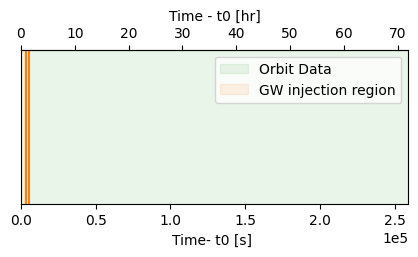

In [189]:
gws = []

# Setup GW Response data lenghts
N_HOURS_OF_OBS = 0.5  # hours
duration = SEC_IN_HOUR * N_HOURS_OF_OBS  # s
size = duration * fs  # samples
t0 = orbits_t0 + 1 * SEC_IN_HOUR  # s
data_kwgs = dict(t0=t0, dt=dt, size=size, orbits=orbits_fn)


def plot_orbit_data_region_vs_gw_response_region():
    gw_injection_region = [t0, (t0 + duration)]

    plt.figure(figsize=(5, 2))
    # shade region from orbit_t[0] to orbit_t[-1]
    plt.axvspan(
        0, (orbit_t[-1] - orbits_t0 ),
        alpha=0.1, color='tab:green',
        label='Orbit Data'
    )

    plt.axvspan(
                (gw_injection_region[0] - orbits_t0),
                (gw_injection_region[1] - orbits_t0),
        alpha=0.1, color='tab:orange',
        label='GW injection region'
    )
    plt.axvline((gw_injection_region[0] - orbits_t0), color='tab:orange')
    plt.axvline((gw_injection_region[1] - orbits_t0), color='tab:orange')

    # remove y-axis labels
    plt.yticks([])
    plt.xlabel('Time- t0 [s] ')
    # use Sci notation for xticks
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    # add secondary xticks on top of plot in hours
    sec2hr = lambda x: x / SEC_IN_HOUR
    hr2sec = lambda x: x * SEC_IN_HOUR

    ax = plt.gca()
    secax = ax.secondary_xaxis('top', functions=(sec2hr, hr2sec))
    secax.set_xlabel('Time - t0 [hr]')


    plt.xlim(0, orbit_duration)
    _ = plt.legend(loc='upper right')

plot_orbit_data_region_vs_gw_response_region()

You are using an orbit file in a version that might not be fully supported


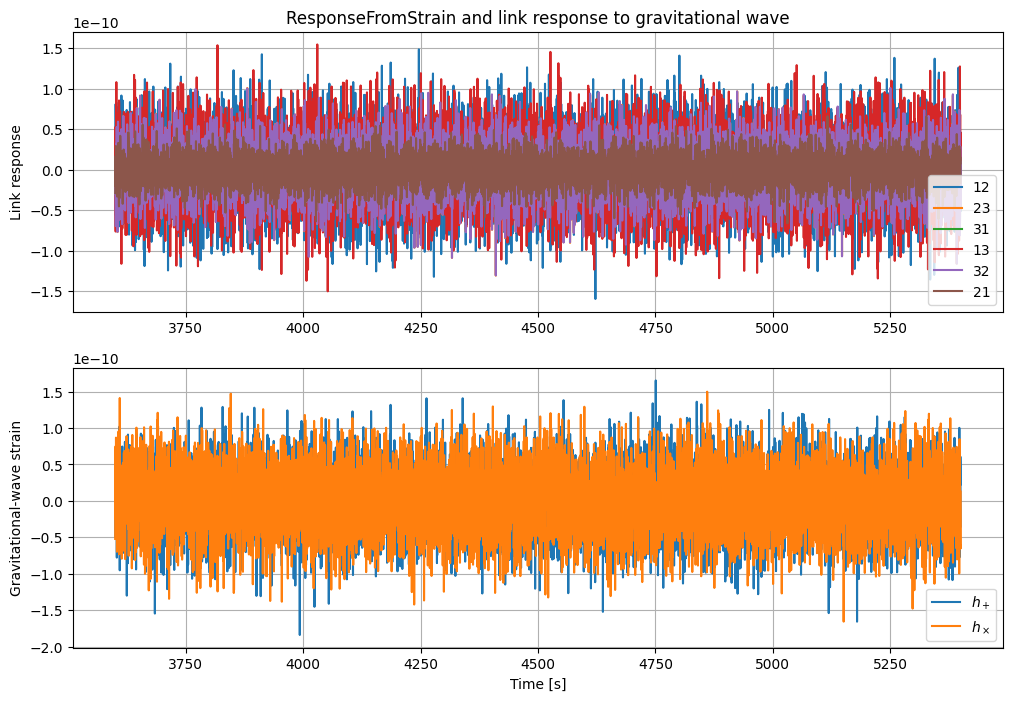

In [190]:
# Create a flat-spectrum source

generator = lisagwresponse.psd.white_generator(1E-21)
gws.append(lisagwresponse.StochasticPointSource(
    generator, gw_beta=0, gw_lambda=0, **data_kwgs,
))
gws[-1].plot(gws[-1].t)

You are using an orbit file in a version that might not be fully supported


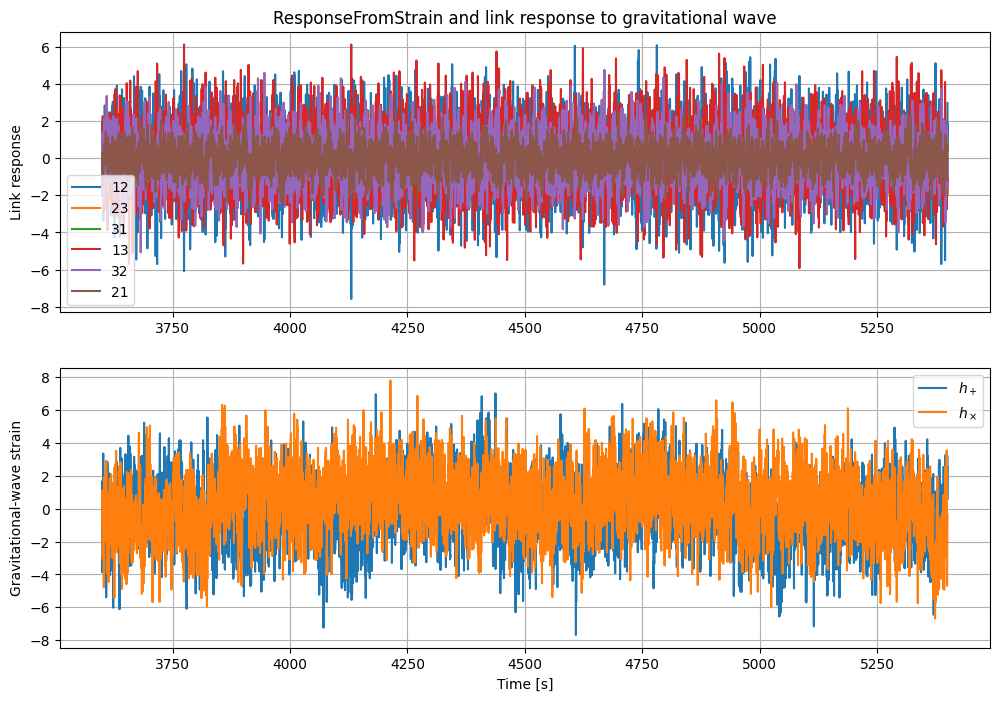

In [191]:
# Create a -2/3 power-law source
generator = lisagwresponse.psd.ifft_generator(lambda f: f ** (-2 / 3))
gws.append(lisagwresponse.StochasticPointSource(
    generator, gw_beta=0, gw_lambda=0, **data_kwgs
))
gws[-1].plot(gws[-1].t)

You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


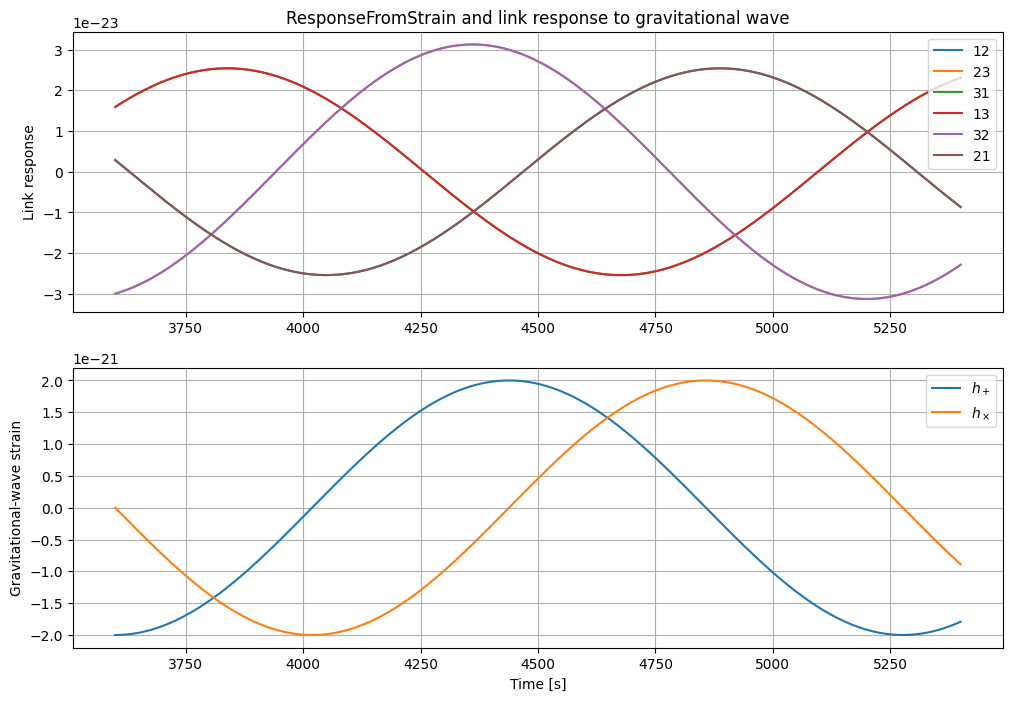

In [192]:
# Create few binaries
n_binaries = 3
A = 1E-21

for i in range(n_binaries):
    f = np.random.uniform(5E-4, 2E-3)
    gws.append(
        lisagwresponse.GalacticBinary(
            A, f,
            gw_beta=0, gw_lambda=0,
            **data_kwgs
        )
    )
gws[-1].plot(gws[-1].t)

In [193]:
# write all GWs into one object
gw_fname = f"{OUTDIR}/gws.hdf5"
if os.path.exists(gw_fname):
    os.remove(gw_fname)  # remove old file
for gw in gws:
    gw.write(gw_fname)

You are using an orbit file in a version that might not be fully supported
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using a GW file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported


## LISA Instrument noise

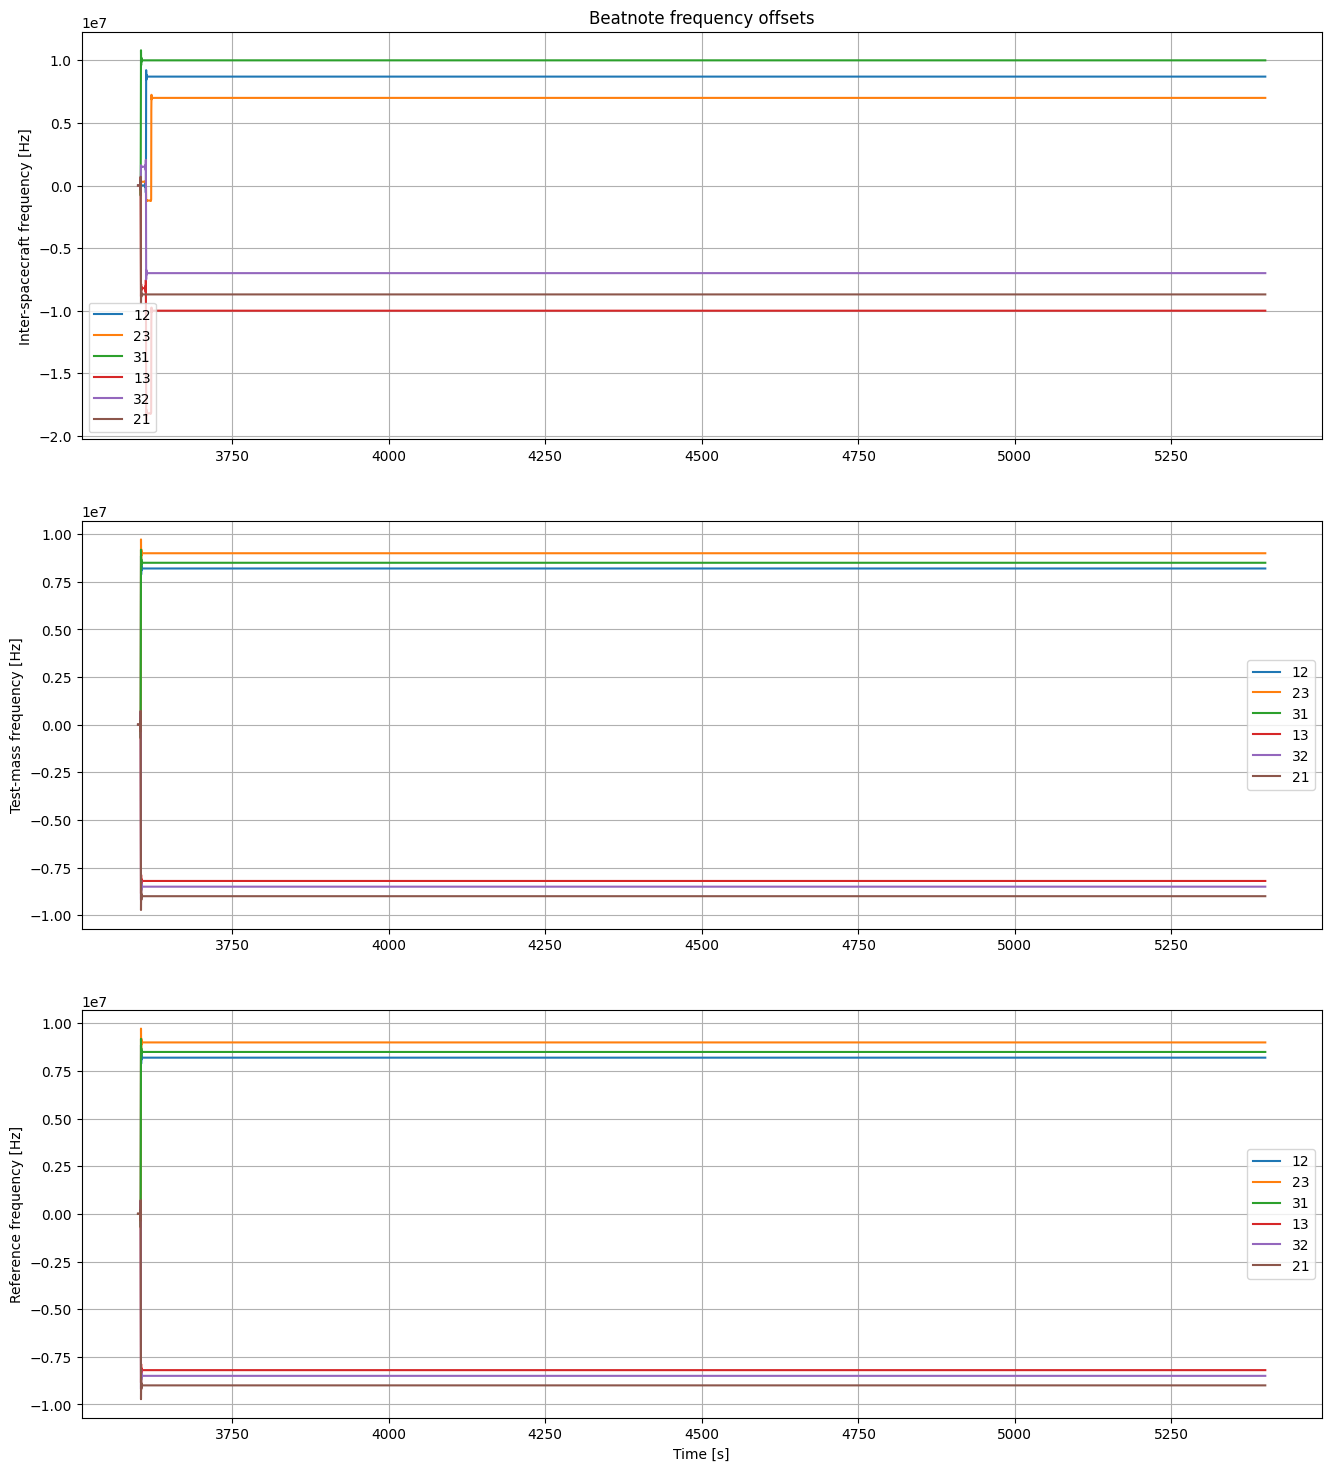

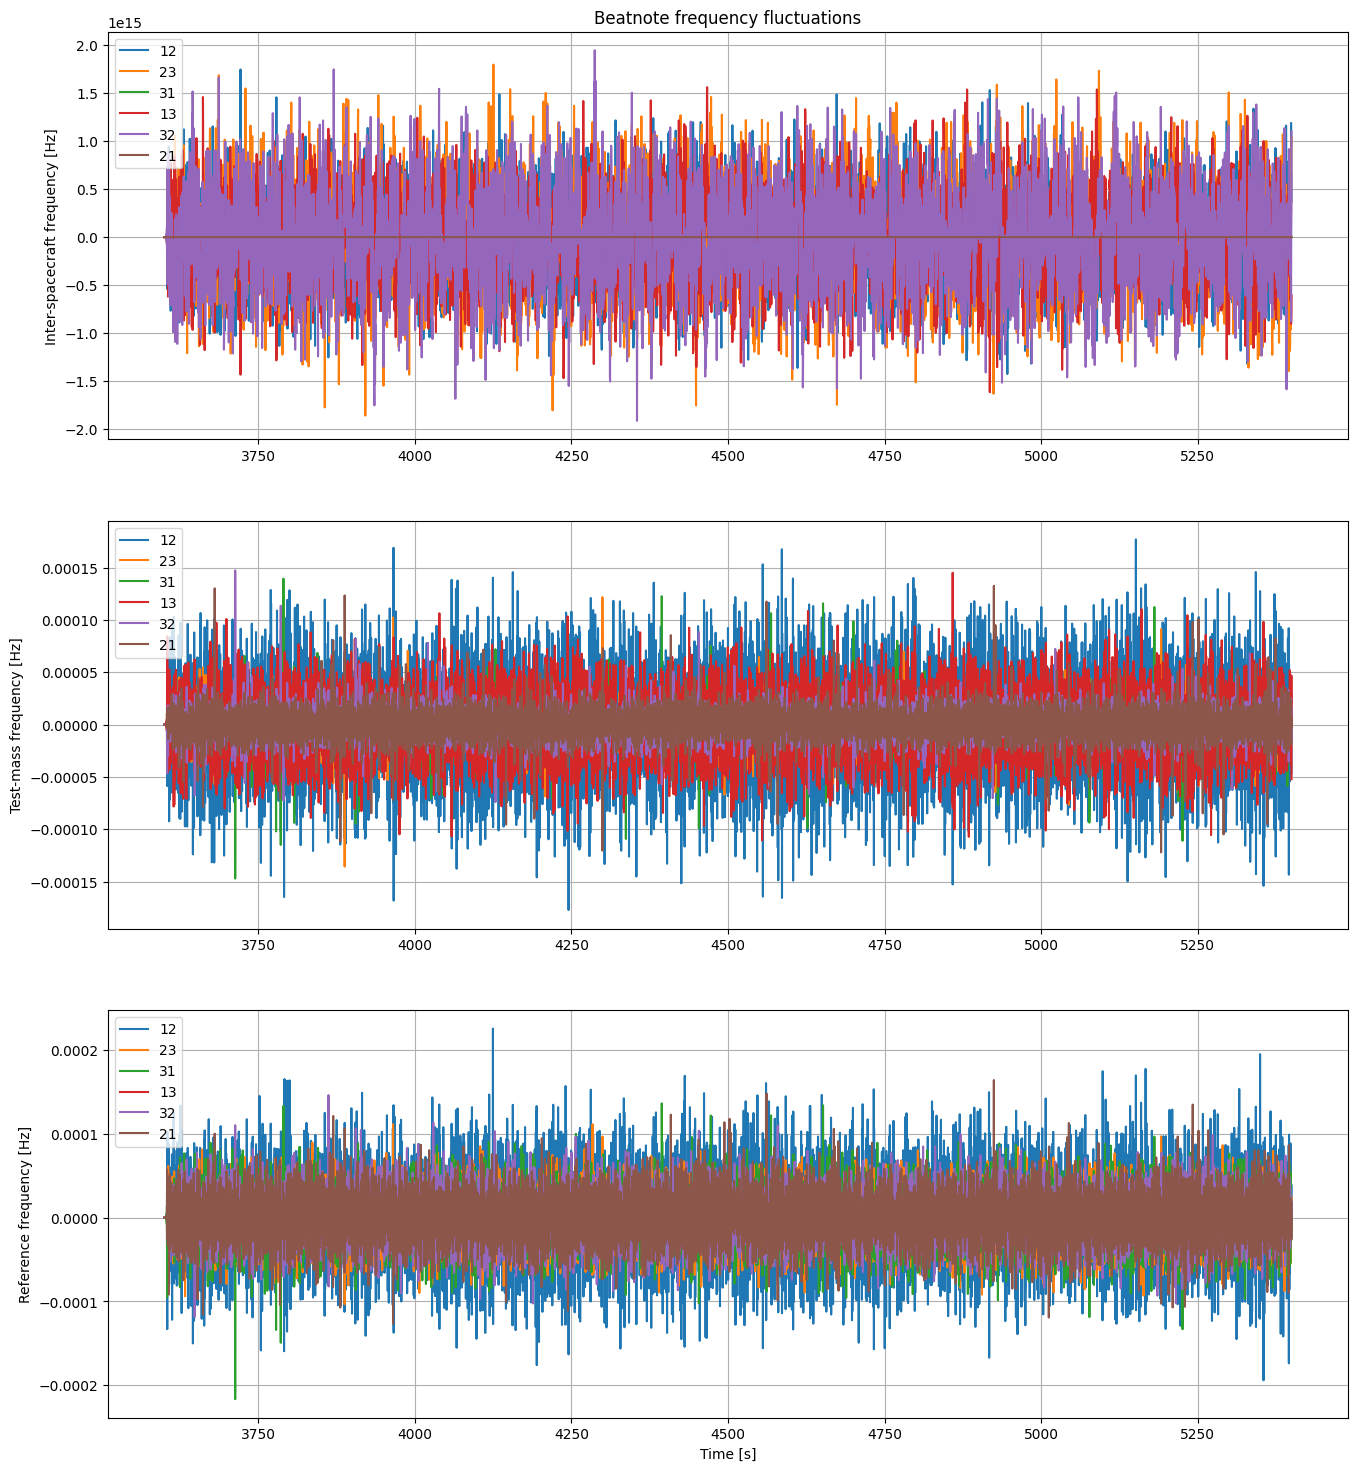

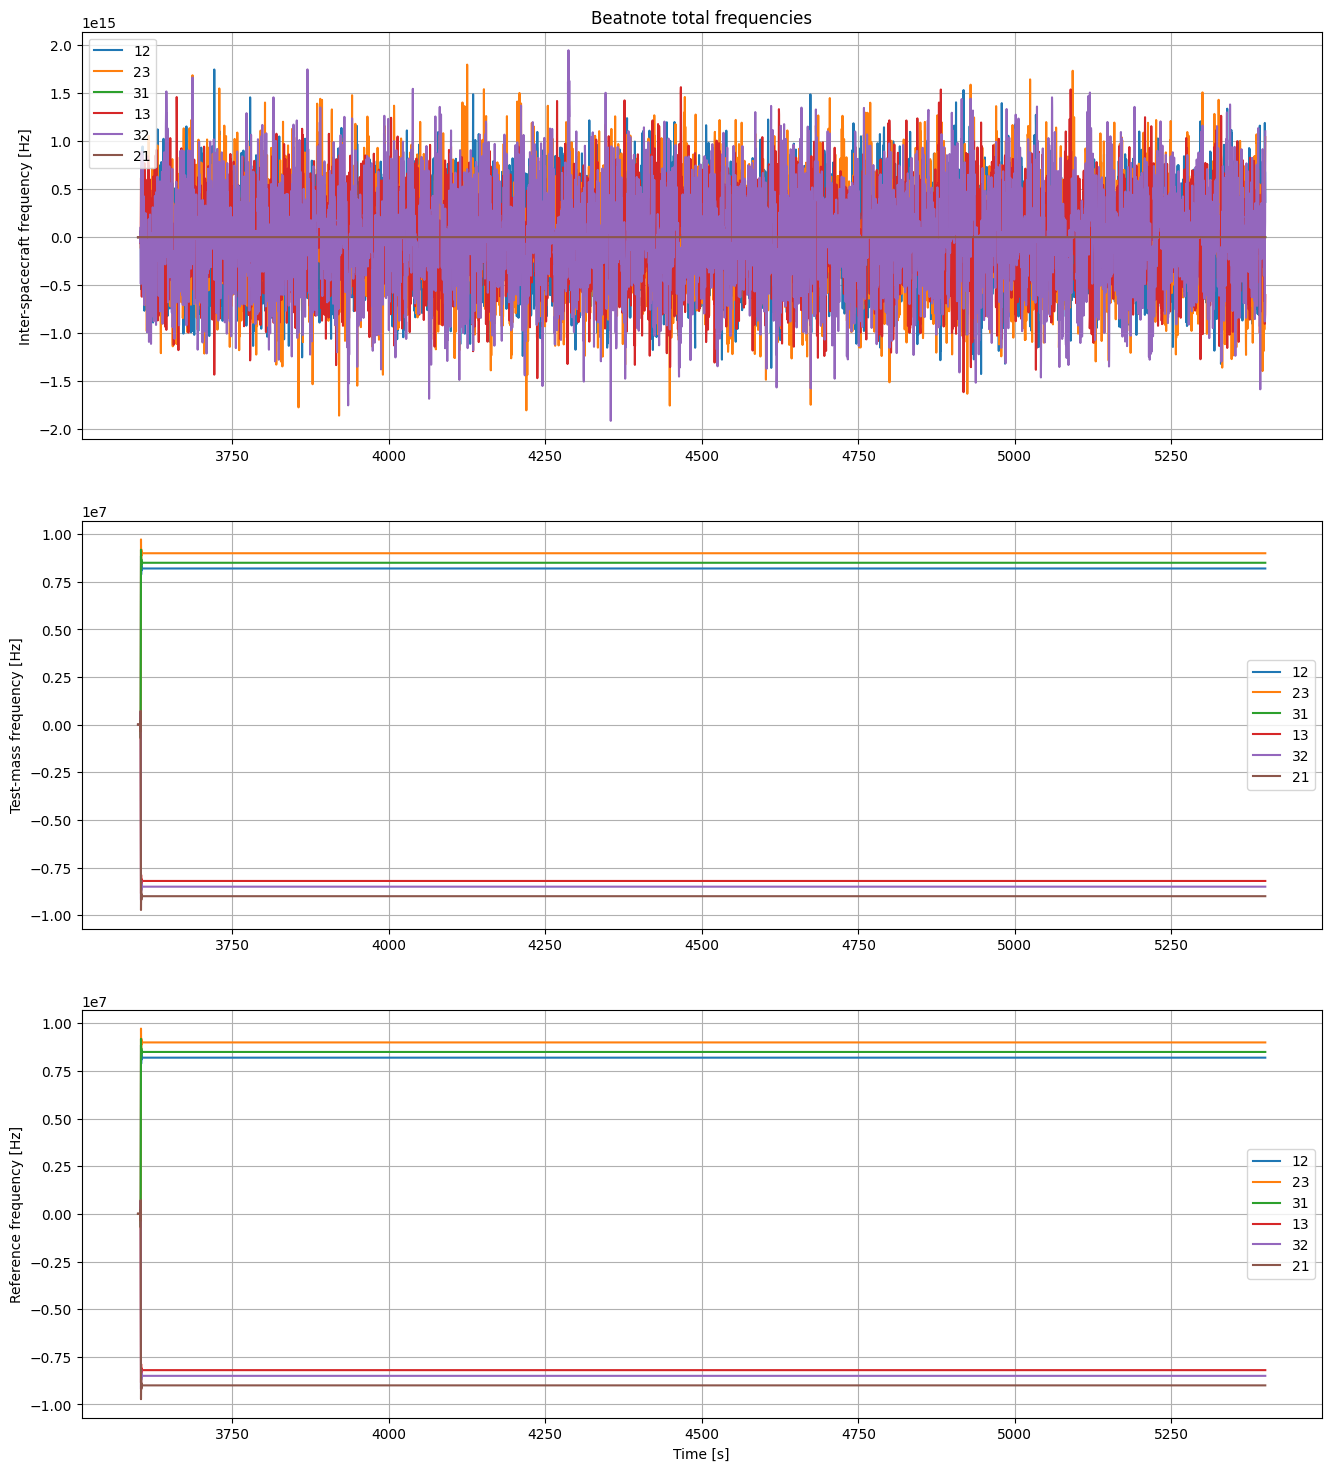

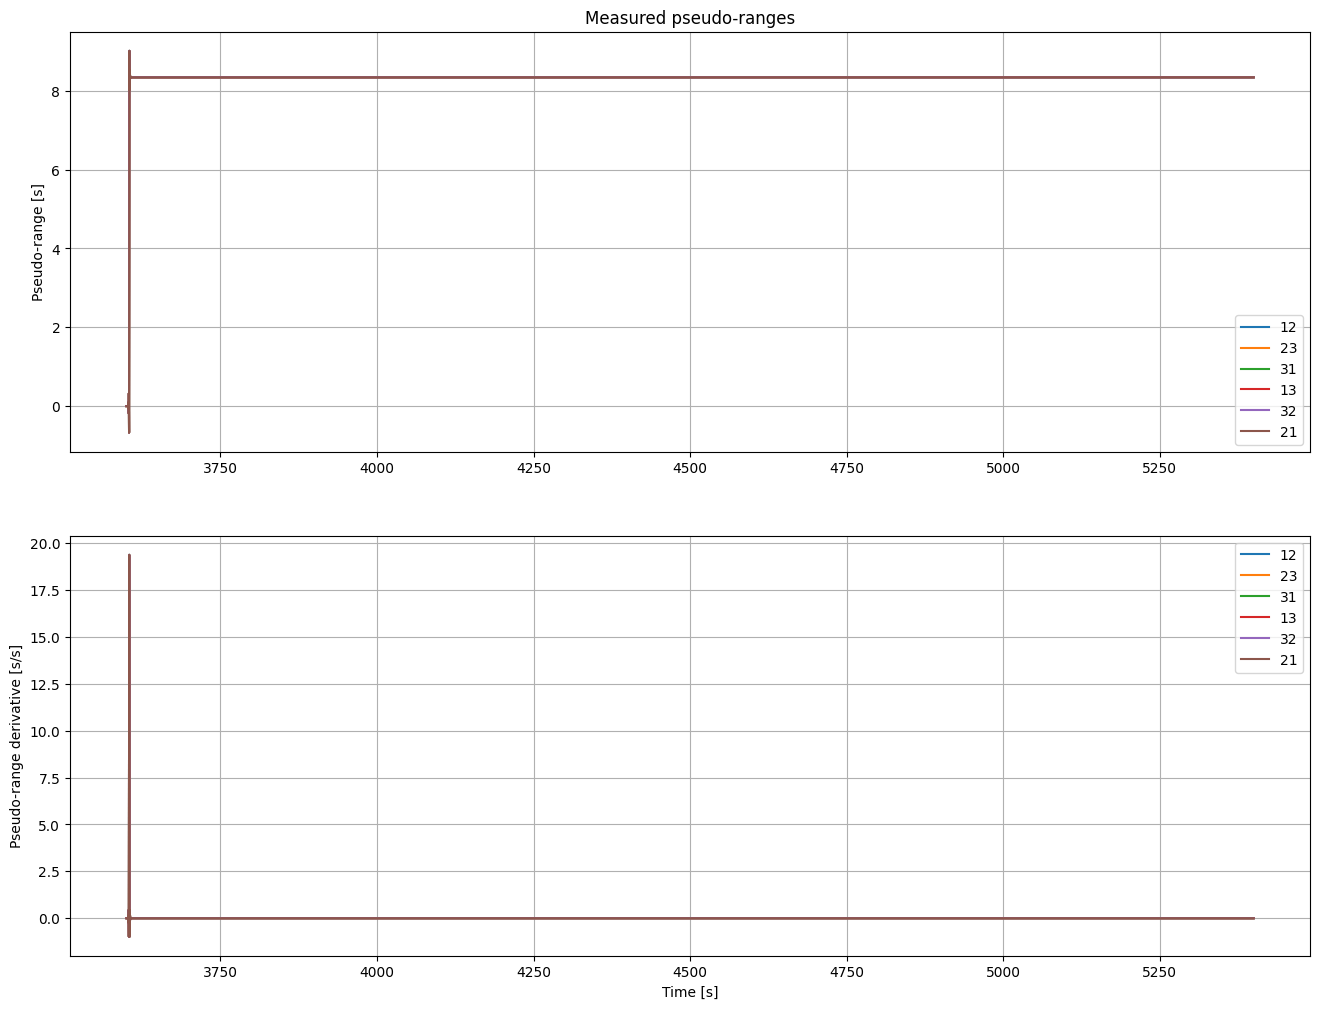

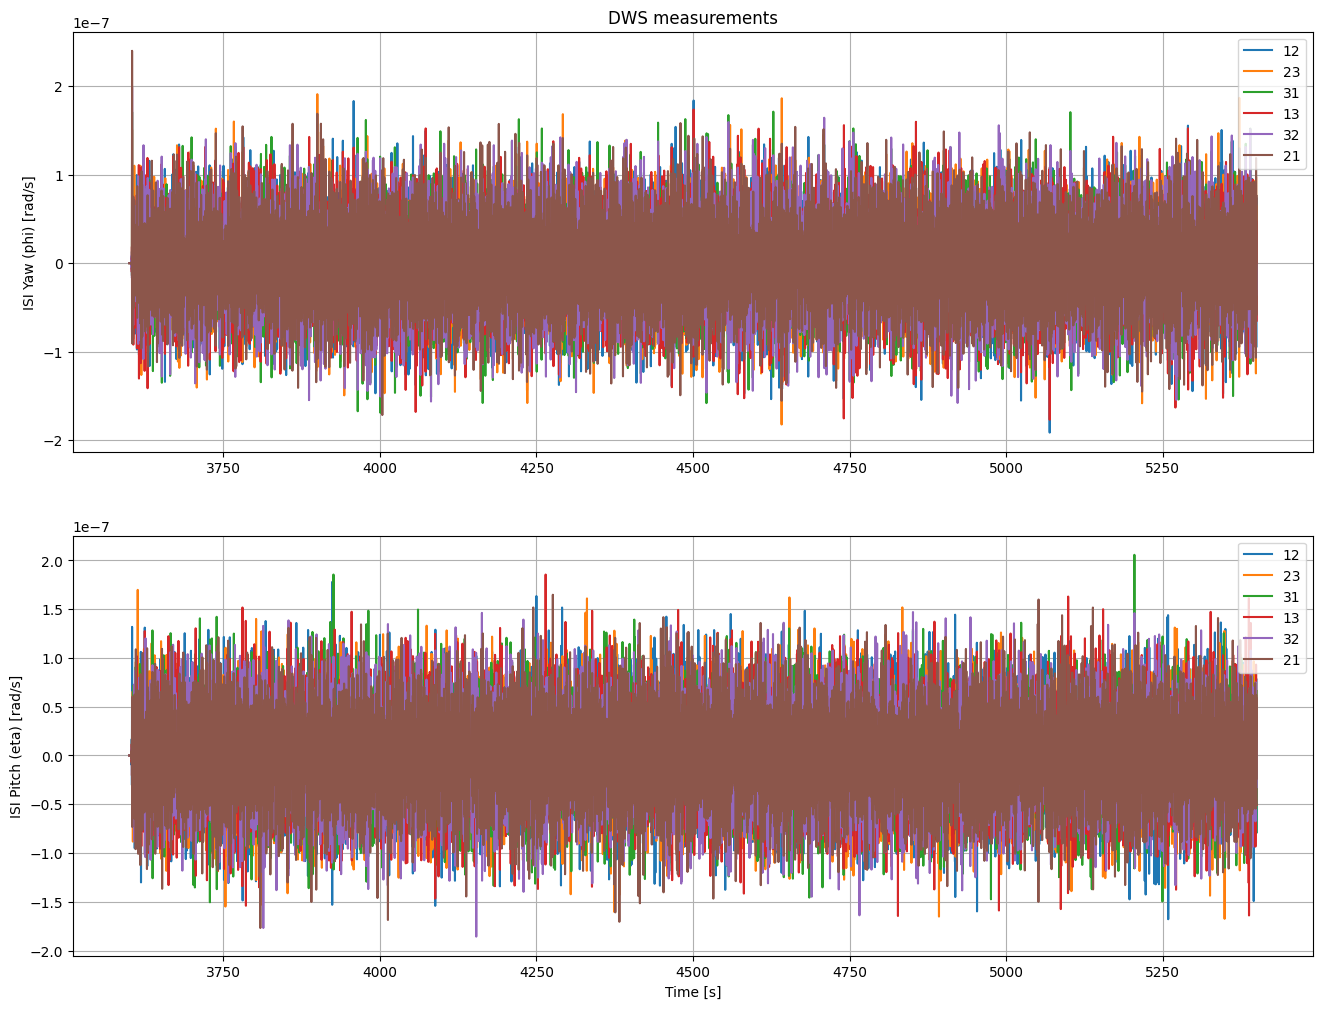

In [194]:
instrument = lisainstrument.Instrument(
    **data_kwgs,
    gws=gw_fname,
)
instrument.simulate()
instrument.plot_offsets()
instrument.plot_fluctuations()
instrument.plot_totals()
instrument.plot_mprs()
instrument.plot_dws()

instrument_fn = f"{OUTDIR}/instrument.hdf5"
if os.path.exists(instrument_fn):
    os.remove(instrument_fn)  # remove old file
instrument.write(instrument_fn)

## TDI observables

In [209]:
from pytdi.michelson import X1
from pytdi import Data

data = Data.from_instrument(instrument_fn)
built = X1.build(**data.args)
X_sim = built(data.measurements)

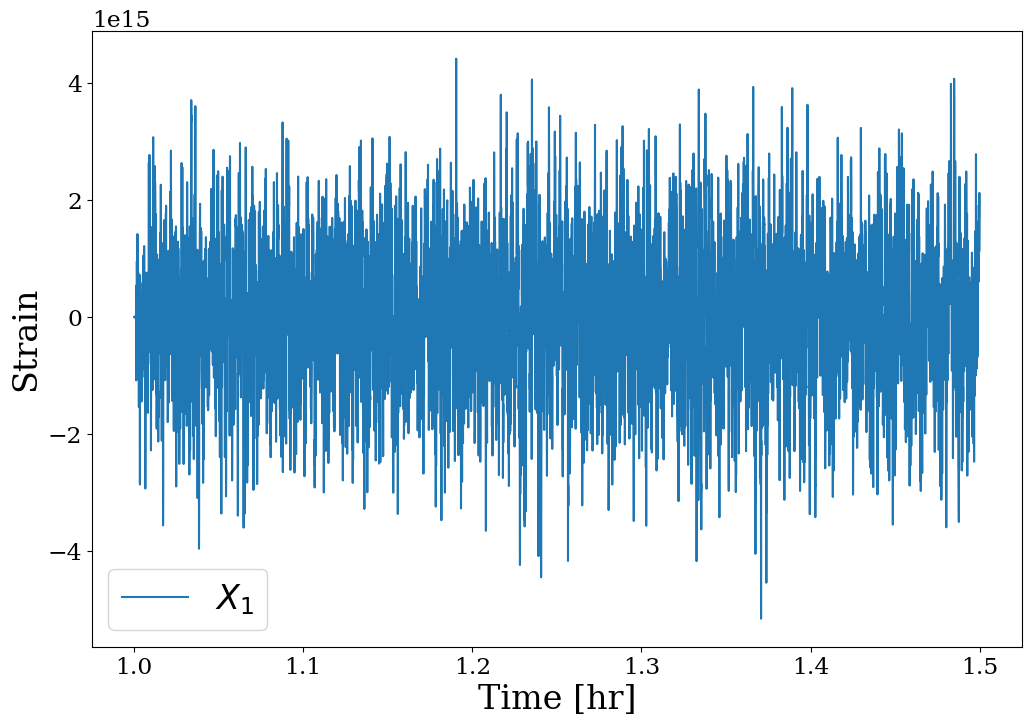

In [224]:
simulation_time = np.arange(0, duration, dt) + t0
plt.plot(simulation_time/SEC_IN_HOUR, X_sim, label='$X_1$')
plt.ylabel('Strain')
plt.xlabel('Time [hr]')
plt.legend()

/Users/avaj0001/Documents/projects/compas_dev/compas_venv/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 65536 is greater than input length  = 7200, using nperseg = 7200
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/qt/rxjvm_j566v9qn7g754s1v9hzb3p7f/T/ipykernel_84121/1801949632.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(freq), 1E-1)


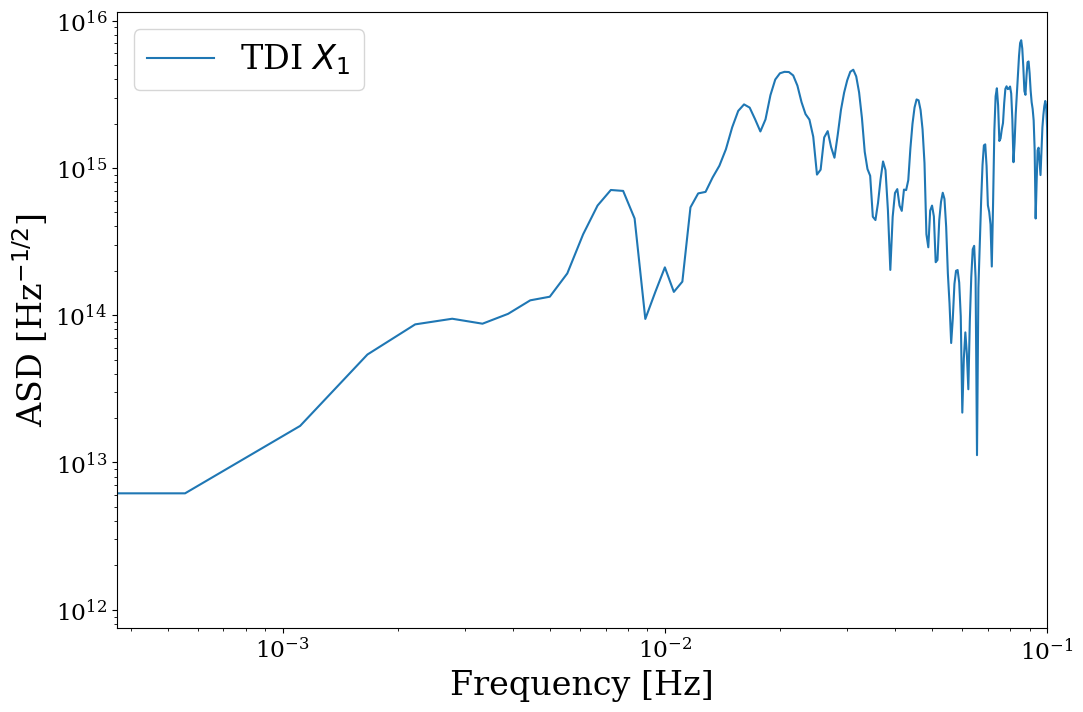

In [225]:
# Plot the TDI Michelson channels
import scipy

psd = lambda tseries: scipy.signal.welch(
    tseries,
    fs=fs,
    nperseg=2**16,
    window=('kaiser', 30),
    detrend=None
)
freq, X_psd = psd(X_sim)
plt.loglog(freq, np.sqrt(X_psd), label=r'TDI $X_1$')
plt.xlim(min(freq), 1E-1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.legend()

(5e-21, 1e-13)

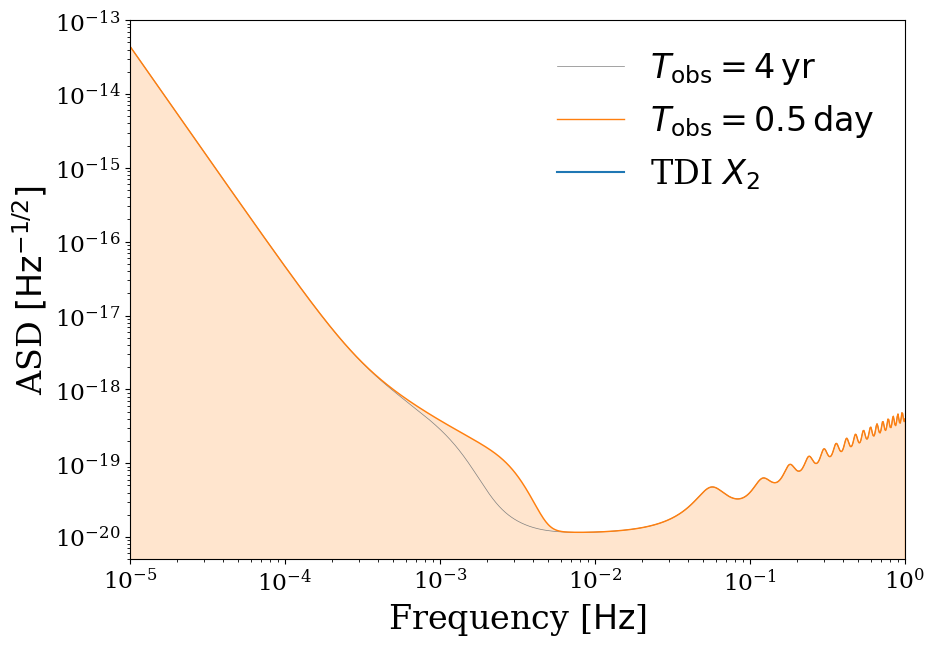

In [223]:
import legwork.visualisation as vis
import astropy.units as u



sensitivity_color  = "tab:orange"
fig, ax = vis.plot_sensitivity_curve(
    t_obs=4 * u.yr, color='tab:gray', label=r"$T_{\rm obs} = 4 \,\rm{yr}$",
    fill=False, show=False, linewidth=0.5
)
fig, ax = vis.plot_sensitivity_curve(
    t_obs=0.5 * u.day, color=sensitivity_color, label=r"$T_{\rm obs} = 0.5 \,\rm{day}$",
    fill=True, show=False, fig=fig, ax=ax,
)

#FIXME: why are the amplitudes so different?
ax.loglog(freq, np.sqrt(X_psd), label=r'TDI $X_2$')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(5e-21, 1e-13)
